In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
housing = pd.read_csv('data/train.csv')
y = housing['SalePrice']
x = housing.drop(columns=['Id', 'SalePrice'])
print(x.head())
print(y.head())

   MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0          60       RL         65.0     8450   Pave   NaN      Reg   
1          20       RL         80.0     9600   Pave   NaN      Reg   
2          60       RL         68.0    11250   Pave   NaN      IR1   
3          70       RL         60.0     9550   Pave   NaN      IR1   
4          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig  ... ScreenPorch PoolArea PoolQC Fence  \
0         Lvl    AllPub    Inside  ...           0        0    NaN   NaN   
1         Lvl    AllPub       FR2  ...           0        0    NaN   NaN   
2         Lvl    AllPub    Inside  ...           0        0    NaN   NaN   
3         Lvl    AllPub    Corner  ...           0        0    NaN   NaN   
4         Lvl    AllPub       FR2  ...           0        0    NaN   NaN   

  MiscFeature MiscVal  MoSold  YrSold  SaleType  SaleCondition  
0         NaN       0       2    2008        WD         N

In [3]:
for col in x:
    num_nans = x[col].isnull().sum() / x.shape[0]
    if num_nans > 0.8: # Drop any columns with more than 80% nans
        print('Dropping column', col, 'which has' , num_nans, 'nans')
        x = x.drop(columns=[col])

Dropping column Alley which has 0.9376712328767123 nans
Dropping column PoolQC which has 0.9952054794520548 nans
Dropping column Fence which has 0.8075342465753425 nans
Dropping column MiscFeature which has 0.963013698630137 nans


In [4]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

numeric_cols = x.select_dtypes(include=np.number).columns.tolist()[1:-1]
categorical_cols = x.select_dtypes(include='object').columns.tolist()

mean_imputer = SimpleImputer()
mean_imputer.fit(x[numeric_cols])
x[numeric_cols] = mean_imputer.transform(x[numeric_cols])

scaler = StandardScaler()
scaler.fit(x[numeric_cols])
x[numeric_cols] = scaler.transform(x[numeric_cols])

encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoder.fit(x[categorical_cols])
encoded_cols = list(encoder.get_feature_names_out())
x[encoded_cols] = encoder.transform(x[categorical_cols])
x = x.drop(columns=categorical_cols)

/usr/lib/python3.9/site-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)


In [5]:
print(x.head())

   MSSubClass  LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  \
0          60    -0.229372 -0.207142     0.651479    -0.517200   1.050994   
1          20     0.451936 -0.091886    -0.071836     2.179628   0.156734   
2          60    -0.093110  0.073480     0.651479    -0.517200   0.984752   
3          70    -0.456474 -0.096897     0.651479    -0.517200  -1.863632   
4          60     0.633618  0.375148     1.374795    -0.517200   0.951632   

   YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  ...  SaleType_ConLw  \
0      0.878668    0.511418    0.575425   -0.288653  ...             0.0   
1     -0.429577   -0.574410    1.171992   -0.288653  ...             0.0   
2      0.830215    0.323060    0.092907   -0.288653  ...             0.0   
3     -0.720298   -0.574410   -0.499274   -0.288653  ...             0.0   
4      0.733308    1.364570    0.463568   -0.288653  ...             0.0   

   SaleType_New  SaleType_Oth  SaleType_WD  SaleCondition_Abnorml  \
0          

In [6]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

/usr/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=2.273e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=2.71555e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=7.75319e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.69701e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=3.7863e-18):

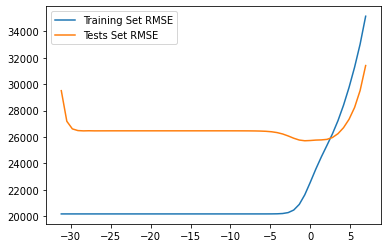

In [16]:
# Regression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge

def linear_regression(alpha):
    model = Ridge(alpha=alpha).fit(x_train, y_train)
    train_preds = model.predict(x_train)
    test_preds = model.predict(x_test)

    train_rmse = np.sqrt(np.mean((train_preds - y_train)**2))
    test_rmse = np.sqrt(np.mean((test_preds - y_test)**2))

    return train_rmse, test_rmse

alpha = np.array([2 ** i for i in range(-45, 11)])
results = np.array([linear_regression(a) for a in alpha])

fig, ax = plt.subplots()
ax.plot(np.log(alpha), results[:, 0], label='Training Set RMSE')
ax.plot(np.log(alpha), results[:, 1], label='Tests Set RMSE')
ax.legend()

In [8]:
# Gaussian Process Regressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, WhiteKernel, DotProduct

def gp_regression():
    kernel = ConstantKernel() * DotProduct()
    model = GaussianProcessRegressor(kernel=kernel).fit(x_train[numeric_cols], y_train)

    train_preds = model.predict(x_train[numeric_cols])
    test_preds = model.predict(x_test[numeric_cols])

    train_rmse = np.sqrt(np.mean((train_preds - y_train)**2))
    test_rmse = np.sqrt(np.mean((test_preds - y_test)**2))

    return model, train_rmse, test_rmse

train_rmse, test_rmse = gp_regression()

print('GP Regression Train RMSE', train_rmse)
print('GP Regression Test RMSE', test_rmse)

ValueError: too many values to unpack (expected 2)